# Determining CSC 2.0 Cumulative Sky Coverage in a Region of the Sky
Scienc thread by Frank Primini. Jupyter notebook by Rafael Martínez-Galarza

This thread describes how to construct a cumulative sky coverage histogram for a region of the sky containing
one or more overlapping CSC 2.0 stacks. This notebook assumes you have installed CIAO 4.13 using conda, but you should also be able to do this with a CIAO installed using the `ciao-install` script, or any other Python environment as we are just going to use [Astropy](https://www.astropy.org/) along with `pyvo`. The `pyyaml` poackage is needed to support writing out the file (it avoids a warning message you would get).

Packages to install:

 - `pip install astropy pyvo pyyaml matplotlib`

In addition, you will need to have the following installations ():

In [1]:
import numpy as np

from matplotlib import pyplot as plt
import matplotlib

import astropy
import pyvo as vo

import scipy

import warnings; warnings.simplefilter('ignore')

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.io import fits

from ciao_contrib.runtool import search_csc, reproject_image_grid, dmimgthresh 
from ciao_contrib.runtool import dmimgfilt, dmcopy, dmimgcalc, dmstat, dmimghist, dmlist

from ciao_contrib.runtool import search_csc

import glob

%matplotlib inline

## Scientific Problem

Number counts or luminosity functions of different classes of x-ray sources allow the determination of those sources' contributions in various astrophysical problems, ranging in scale from specific galaxy populations to the overall contribution the the cosmic x-ray background.
To determine the number counts of sources in flux-limited surveys, one needs to know the cumulative sky coverage $\Omega(F>F_{min})$, i.e., the survey area in which a source brighter than flux $F_{min}$ could be detected, as a function of $F_{min}$ (see, e.g. [Miyaji et al. (2015)](https://iopscience.iop.org/article/10.1088/0004-637X/804/2/104)).

Sky coverage can be determined from a map of limiting sensitivity, defined as the minimum flux required to include a source in the survey. Although *CSC 2.0*, includes an all-sky limiting sensitivity map which users can query at specific locations, using CSCview, there is, at present, no capability to download subsets of the map for arbitrary regions of the sky. However, the equivalent information may be recovered from the limiting sensitivity data products provided for individual *CSC 2.0*, stacks. In this thread we use CSCview to determine and download the limiting sensitivity data products for a particular region of the sky, and analyze them with *CIAO* to construct the cumulative sky coverage for the region.


## Determining stacks in a region of the sky

For our example, we choose a $12^{\prime}$ radius circular region centered at $\alpha=164.05, \delta=57.2$ in the southeast corner of the larger *Chandra* Lockman Hole Survey. Here is a visualization of the region in the [*Chandra* Footprint Service](https://cxcfps.cfa.harvard.edu/cda/footprint/cdaview.html):

![M33](CSC_footprint.png)

The Service identifies 6 OBSIDS, 1682, 1686, 1687, 1691, 1692, and 1693, that overlap the region. Let's start by defning the region that we want to query:

In [2]:
# Define region

c = SkyCoord(164.05, 57.2, unit="deg")
maxrad = 0.2 * u.deg

We now query the Catalog using our cone search service and `pyvo` to determine the sources that fall within our region of interest. We use the coordinate object that we have just defined. We then print the names of the *CSC 2.0* sources that fall withing the region of interest, and save the names in a list (tnames) for later use.

In [3]:
# Search for CSC sources within the defined region
cone = vo.dal.SCSService('http://cda.cfa.harvard.edu/csc2scs/coneSearch')
results = cone.search(pos=c, radius=maxrad, verbosity=3)

In [4]:
# Get the names of the sources and 
names = results['name'].data.astype('str')
tnames = tuple(names)
print(tnames)

('2CXO J105501.8+571351', '2CXO J105507.3+570857', '2CXO J105517.3+571650', '2CXO J105518.1+570423', '2CXO J105523.3+570322', '2CXO J105525.5+571213', '2CXO J105531.4+571757', '2CXO J105534.7+571338', '2CXO J105535.2+570412', '2CXO J105541.5+570926', '2CXO J105543.2+571016', '2CXO J105544.8+571140', '2CXO J105545.3+571701', '2CXO J105551.6+571101', '2CXO J105555.4+571257', '2CXO J105556.1+570445', '2CXO J105601.4+570702', '2CXO J105604.4+571247', '2CXO J105605.6+571405', '2CXO J105605.7+570450', '2CXO J105605.7+572258', '2CXO J105606.2+571351', '2CXO J105609.8+571508', '2CXO J105610.1+572109', '2CXO J105614.7+570518', '2CXO J105643.9+570842', '2CXO J105644.6+572234', '2CXO J105646.9+571830', '2CXO J105657.4+570705', '2CXO J105658.7+572158', '2CXO J105719.6+571222', '2CXO J105731.6+570938')


We now want to find the association between these sources and the specific Chandra observations and stacks that contain them (remember that in *CSC 2.0* we stack individual observations to improve detection). In order to make these associations, we use the the catalog's Table Access Protocol service, which we query using `pyvo`. We retrieve the source name, coordinates, and the obsid, stack and region number that identify each detection of each of our sources (for more on how to do TAP queries see [this tutorial](https://github.com/juramaga/CSC2_tutorials/blob/main/CDS2021_CSC2_tutorial.ipynb)):

In [5]:
# Define a TAP query to get the coordinates, detect stacks, obsids, and regions where the sources are detected
qry = """
SELECT m.name, m.ra, m.dec, s.detect_stack_id, s.ra_stack, s.dec_stack, o.obsid, o.region_id
FROM csc2.master_source m, csc2.master_stack_assoc a, csc2.observation_source o, 
    csc2.stack_observation_assoc b, csc2.stack_source s
WHERE m.name IN {} 
    AND (m.name = a.name) AND (s.detect_stack_id = a.detect_stack_id and s.region_id = a.region_id) 
    AND (s.detect_stack_id = b.detect_stack_id and s.region_id = b.region_id) 
    AND (o.obsid = b.obsid and o.obi = b.obi and o.region_id = b.region_id)
""".format(tnames)

In [6]:
# Run the TAP query
tap = vo.dal.TAPService('http://cda.cfa.harvard.edu/csc2tap')
cat = tap.search(qry)

Let us now list the results in a table format. For each source, we list each individual observation where the source was detected, and the corresponding stack ID:

In [7]:
# Convert to a table
cat.to_table()

name,ra,dec,detect_stack_id,ra_stack,dec_stack,obsid,region_id
,deg,deg,,deg,deg,,
object,float64,float64,object,float64,float64,int32,int32
2CXO J105535.2+570412,163.89670921106836,57.07006015047436,acisfJ1055396p571215_001,163.915366974,57.2041755575,1691,4
2CXO J105605.7+572258,164.02414209129165,57.38288054476326,acisfJ1056316p572714_001,164.132030824,57.4541029016,1693,17
2CXO J105646.9+571830,164.19543902065288,57.308454840062396,acisfJ1056307p571215_001,164.127931168,57.2042703815,1692,10
2CXO J105657.4+570705,164.23919634695233,57.11806698688593,acisfJ1056307p571215_001,164.127931168,57.2042703815,1692,7
2CXO J105501.8+571351,163.75775428894497,57.231066977268604,acisfJ1052487p571215_001,163.202960947,57.2042150159,1682,31
2CXO J105501.8+571351,163.75775428894497,57.231066977268604,acisfJ1055396p571215_001,163.915366974,57.2041755575,1691,8
2CXO J105507.3+570857,163.78056896765577,57.14921603579359,acisfJ1052487p571215_001,163.202960947,57.2042150159,1682,32
2CXO J105507.3+570857,163.78056896765577,57.14921603579359,acisfJ1055396p571215_001,163.915366974,57.2041755575,1691,10


# Downloading the data products: sensitivity maps

In order to estimate the cumulative sky coverage, we need to use the [stack level sensitivity maps](https://cxc.harvard.edu/csc/data_products/stack/sens3.html), which record for each stack the limiting sensitivity for a point source to exceed the MLE likelihood thresholds at each location in the field, i.e., the the minimum photom flux that a source can have in order to be detected as a TRUE or MARGINAL in that particular stack.

We wish to obtain the s band limiting sensitivity maps corresponding to the detect_stack_ids that we have identified. Here we will be using the *soft* band sensitivity maps (multiple energy bands can be retrieved at the same time, but for our example we're only interested in the s band).  

In order to download the data products, we use *CIAO*'s [`search_csc`](https://cxc.cfa.harvard.edu/ciao/ahelp/search_csc.html) tool, which takes the coordinates of a source as input, or a SIMBAD-resolved name. For each unique stack name, we select the first listed source from the table above to perform the query. This operation will download the sensitivity maps for each of the stacks that overlap our region of interest. Some of them will be downloaded more than once because a given source can be detected in more than one stack, and we are using the coordinates of a source in order to retrieve the data products. We therefore need to get the unique files after the download, as shown below:

In [8]:
# Extract the unique names of the 6 stacks where the sources have been detected, 
# and run search_csc to download the sens3 maps
unique_stacks = np.unique(cat['detect_stack_id'].data)
for stack in unique_stacks:
    ind_stack = np.where(cat['detect_stack_id'].data==stack)[0][0]  # We select only one source in each stack, because
                                                                    # the sens3 file will be the same for all sources
                                                                    # in that stack
    search_csc('{}, {}'.format(str(cat['ra'][ind_stack]),str(cat['dec'][ind_stack])), '1', 
               'source_search.tsv', 'arcsec', '', '', 'all', '/Users/juan/L3/tutorial/sens_maps', 
               'soft', 'sensity', 'csc2','1','1')

In [9]:
# Get the list of sens3 files names
sens_files = []
for file in glob.glob('/Users/juan/L3/tutorial/sens_maps/*/*/*gz'):
    sens_files.append(file[80:])
    

In [10]:
# Get the unique files 
unique_sens_files = np.unique(sens_files)
print(unique_sens_files)

['acisfJ1052487p571215_001N022_s_sens3.fits.gz'
 'acisfJ1054386p565715_001N022_s_sens3.fits.gz'
 'acisfJ1054407p572715_001N022_s_sens3.fits.gz'
 'acisfJ1055396p571215_001N022_s_sens3.fits.gz'
 'acisfJ1056307p571215_001N022_s_sens3.fits.gz'
 'acisfJ1056316p572714_001N022_s_sens3.fits.gz']


## Analyzing Limiting Sensitivity Map Data
The organization of the sensitivity maps is described in our [documentation pages](https://cxc.cfa.harvard.edu/csc/data_products/stack/sens3.html). For our example, we'll look at the sensitivities corresponding to detections with likelihood classification *TRUE*, found in the second fits extension of the sens3.fits file.

### Visualizing the Maps

We can examine the sensitivity maps to get an idea of where they fall with respect to our circular region of interest. We do this below using astropy's WCS package, which allows us to show the sensitivity maps in the coordinate reference frame defined in the header of the files: 

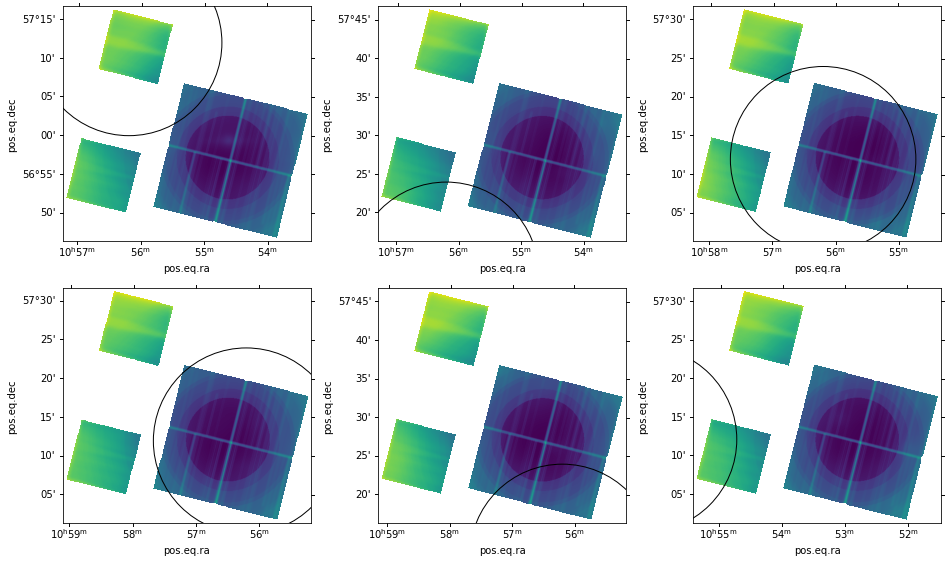

In [11]:
# Show the sensitivity maps with the region of interest
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import WCSAxes
import pyregion
from pyregion.mpl_helper import properties_func_default

ind_plot = np.arange(len(unique_sens_files))
X_plot,Y_plot = np.unravel_index(ind_plot, (2,3), order='C')
fig = plt.figure(figsize=(16, 9.5)) 
fig.tight_layout()
reg_name = 'fk5;circle(164.05, 57.2, 0.2)'
for j in range(len(unique_sens_files)):
    for i,file in enumerate(glob.glob('/Users/juan/L3/tutorial/sens_maps/*/*/{}'.format(unique_sens_files[j]))):
        if (i == 0):
            hdu = fits.open(file)
            wcs = WCS(hdu[0].header)
    
            ax = plt.subplot('23'+str(j), projection=wcs)
            r = pyregion.parse(reg_name).as_imagecoord(hdu[0].header)
            patch_list, artist_list = r.get_mpl_patches_texts()
                
            for p in patch_list:
                ax.add_patch(p)
            
            ax.imshow(np.log10(hdu[0].data))
        else:
            continue

### Creating a sensitivity map mosaic
Our circular region is located in different image coordinates in each map. To combine the maps properly we need to reproject them to a common coordinate system. We do this below using *CIAO*'s [`reproject_image_grid`](https://cxc.harvard.edu/ciao/ahelp/reproject_image_grid.html) tool. We use `reproject_image_grid` to reproject each sensitivity map to a common WCS, centered at $\alpha=164.05, \delta=57.2$. We use a blocking factor of $8$ to match the blocking of the sensitivity maps. The *pixelsize* parameter for `reproject_image_grid` is then

\begin{equation*}
    pixelsize = \frac{0.492^{{\prime}{\prime}} \times 8}{3600.0} = 1.09333\times10^{-3} deg.
\end{equation*}

To ensure that our mosaic encompass the entire $12^{\prime}$ radius circle, we require the `reproject_image_grid` *xsize* and *ysize* parameters to be

\begin{equation*}
    xsize = ysize = \frac{24.0/60.0}{1.09333\times10^{-3}} = 365.85
\end{equation*}
which we round up to $366$. We can then reproject each sensitivity map:

In [12]:
# Reproject the maps
for j in range(len(unique_sens_files)):
    for i,file in enumerate(glob.glob('/Users/juan/L3/tutorial/sens_maps/*/*/{}'.format(unique_sens_files[j]))):
        if (i == 0):
            print(i,file)
            reproject_image_grid(file, file+'2', xsize=366, ysize=366, xcen=164.05, ycen=57.2, 
                                 pixelsize =1.0933333333E-3, theta=0, clobber='yes')

0 /Users/juan/L3/tutorial/sens_maps/2CXOJ105501.8+571351/acisfJ1052487p571215_001/acisfJ1052487p571215_001N022_s_sens3.fits.gz
0 /Users/juan/L3/tutorial/sens_maps/2CXOJ105518.1+570423/acisfJ1054386p565715_001/acisfJ1054386p565715_001N022_s_sens3.fits.gz
0 /Users/juan/L3/tutorial/sens_maps/2CXOJ105644.6+572234/acisfJ1054407p572715_001/acisfJ1054407p572715_001N022_s_sens3.fits.gz
0 /Users/juan/L3/tutorial/sens_maps/2CXOJ105644.6+572234/acisfJ1055396p571215_001/acisfJ1055396p571215_001N022_s_sens3.fits.gz
0 /Users/juan/L3/tutorial/sens_maps/2CXOJ105646.9+571830/acisfJ1056307p571215_001/acisfJ1056307p571215_001N022_s_sens3.fits.gz
0 /Users/juan/L3/tutorial/sens_maps/2CXOJ105605.7+572258/acisfJ1056316p572714_001/acisfJ1056316p572714_001N022_s_sens3.fits.gz


We display the reprojected maps no, but here we match *all* frames using their WCS values. The result
is shown below. All reprojected maps are properly centered about our circular region.

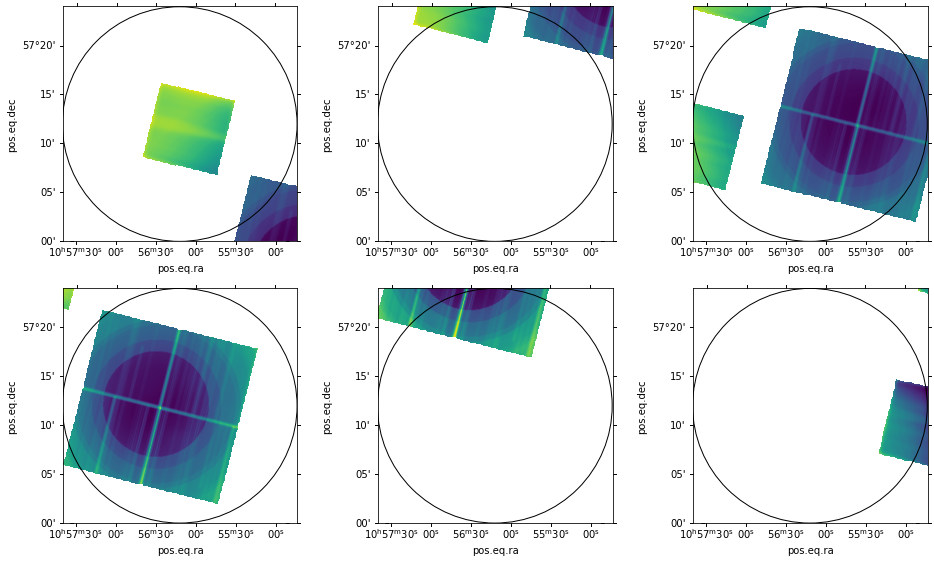

In [13]:
# Show the reprojected sensitivity maps with the region of interest
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import WCSAxes
import pyregion
from pyregion.mpl_helper import properties_func_default

ind_plot = np.arange(len(unique_sens_files))
X_plot,Y_plot = np.unravel_index(ind_plot, (2,3), order='C')
fig = plt.figure(figsize=(16, 9.5)) 
fig.tight_layout()
reg_name = 'fk5;circle(164.05, 57.2, 0.2)'
for j in range(len(unique_sens_files)):
    for i,file in enumerate(glob.glob('/Users/juan/L3/tutorial/sens_maps/*/*/{}2'.format(unique_sens_files[j]))):
        if (i == 0):
            hdu = fits.open(file)
            wcs = WCS(hdu[0].header)
    
            ax = plt.subplot('23'+str(j), projection=wcs)
            r = pyregion.parse(reg_name).as_imagecoord(hdu[0].header)
            patch_list, artist_list = r.get_mpl_patches_texts()
                
            for p in patch_list:
                ax.add_patch(p)
            
            ax.imshow(np.log10(hdu[0].data))
        else:
            continue

But now note that the pixels outside the chip boundaries appear to have two different values. Those in the original
image space (gray) appear as INDEF. However, those in the reprojected image outside the original image space
(black) are set to 0. Before combining the reprojected maps we need to set these to INDEF as well. We use the
CIAO tool [`dmimgthresh`](https://cxc.harvard.edu/ciao/ahelp/dmimgthresh.html) to set all values below a very small positive number to INDEF.

In [14]:
# Set small values to INDEF
for j in range(len(unique_sens_files)):
    for i,file in enumerate(glob.glob('/Users/juan/L3/tutorial/sens_maps/*/*/{}2'.format(unique_sens_files[j]))):
        if (i == 0):
            print(i,file)
            dmimgthresh(file, file+'tr', cut=1.0E-20, value='INDEF', clobber='yes')

0 /Users/juan/L3/tutorial/sens_maps/2CXOJ105501.8+571351/acisfJ1052487p571215_001/acisfJ1052487p571215_001N022_s_sens3.fits.gz2
0 /Users/juan/L3/tutorial/sens_maps/2CXOJ105518.1+570423/acisfJ1054386p565715_001/acisfJ1054386p565715_001N022_s_sens3.fits.gz2
0 /Users/juan/L3/tutorial/sens_maps/2CXOJ105644.6+572234/acisfJ1054407p572715_001/acisfJ1054407p572715_001N022_s_sens3.fits.gz2
0 /Users/juan/L3/tutorial/sens_maps/2CXOJ105644.6+572234/acisfJ1055396p571215_001/acisfJ1055396p571215_001N022_s_sens3.fits.gz2
0 /Users/juan/L3/tutorial/sens_maps/2CXOJ105646.9+571830/acisfJ1056307p571215_001/acisfJ1056307p571215_001N022_s_sens3.fits.gz2
0 /Users/juan/L3/tutorial/sens_maps/2CXOJ105605.7+572258/acisfJ1056316p572714_001/acisfJ1056316p572714_001N022_s_sens3.fits.gz2


We can now combine the individual maps into a mosaic, using the CIAO tool [`dmimgfilt`](https://cxc.cfa.harvard.edu/ciao/ahelp/dmimgfilt.html). We use this tool so
that we can follow the prescription that when two or more maps contribute to the same image pixel, the map
with the lowest pixel value should be used. Before we do this, we create a list with the reprojected maps:

In [19]:
# Print the reprojected files to a list

with open('thresh.lis', 'w') as f:
    for j in range(len(unique_sens_files)):
        for i,file1 in enumerate(glob.glob('/Users/juan/L3/tutorial/sens_maps/*/*/{}2tr'.format(unique_sens_files[j]))):
            if (i == 0):
                print(file1, file = f)
f.close()

And now we run the mosaic maker, and visualize it:

In [15]:
# Create the mosaic
dmimgfilt(infile='@thresh.lis', outfile='sens3_mosaic.fits', function = 'min', mask = "point (0 ,0)", clobber='yes')

omit - DEC_NOM values different more than 0.000300
omit - RA_NOM values different more than 0.000300

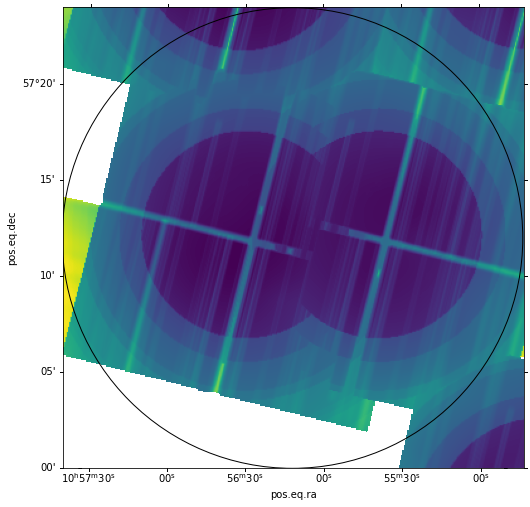

In [16]:
# Show the mosaic

hdu = fits.open('sens3_mosaic.fits')
wcs = WCS(hdu[0].header)
fig = plt.figure(figsize=(12, 8))
ax = WCSAxes(fig, [0.1, 0.1, 0.8, 0.8], wcs=wcs)
fig.add_axes(ax)

ax.imshow(np.log10(hdu[0].data))

r = pyregion.parse(reg_name).as_imagecoord(hdu[0].header)
patch_list, artist_list = r.get_mpl_patches_texts()

for p in patch_list:
    ax.add_patch(p)
for t in artist_list:
    ax.add_artist(t)

Finally, we apply a spatial filter to the mosaic to null out values outside our circle, using *CIAO*'s [`dmcopy`](https://cxc.harvard.edu/ciao/ahelp/dmcopy.html), and visualize the filtered version:

In [17]:
# Make region cutout
dmcopy("sens3_mosaic.fits[(x,y) = circle (164.05d ,57.2d ,12.0')][ opt null = INDEF]", 
       "filt_sens3_mosaic.fits", clobber='yes')

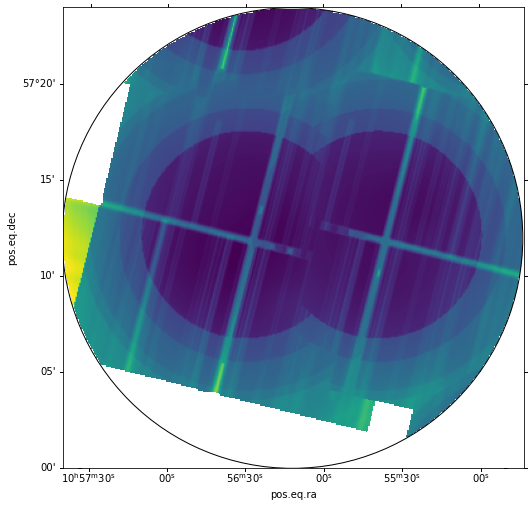

In [18]:
# Show filtered region
hdu = fits.open('filt_sens3_mosaic.fits')
wcs = WCS(hdu[0].header)
fig = plt.figure(figsize=(12, 8))
ax = WCSAxes(fig, [0.1, 0.1, 0.8, 0.8], wcs=wcs)
fig.add_axes(ax)

ax.imshow(np.log10(hdu[0].data))

r = pyregion.parse(reg_name).as_imagecoord(hdu[0].header)
patch_list, artist_list = r.get_mpl_patches_texts()

for p in patch_list:
    ax.add_patch(p)
for t in artist_list:
    ax.add_artist(t)

### Calibrating the mosaic

As discussed in the "Limiting Sensitivity and Sky Coverage" section of the
[Catalog Statistical Characterization](https://cxc.cfa.harvard.edu/csc/char.html) web page, the sensitivity maps are in units of $p_{min}$, the photon flux that corresponds to the minimum Poisson background fluctuation in the source aperture that would exceed the source detection likelihood threshold. To convert to the equivalent photon or energy flux derived from the likelihood of the PSF fit, which is actually used in the detection process, we need to apply a calibration. For energy flux in the s band, that calibration relation is

\begin{equation*}
    log_{10}(Flux) = 1.028 \times log_{10}(p_{min}) - 8.595,
\end{equation*}

which we apply using [`dmimgcalc`](https://cxc.harvard.edu/ciao/ahelp/dmimgcalc.html).

In [19]:
# Calibrate the mosaic
dmimgcalc(infile = 'filt_sens3_mosaic.fits', infile2 = 'none', 
          op = 'imgout=1.028*log(img1)-8.595', outfile = 'logFlux.fits', clobber='yes')

We choose to keep the log of the sensitivity, since we want our ultimate sky coverage histogram to be in logarithmic bins.

### Computing a Sky Coverage Histogram from the Mosaic

If we are only interested in a spatial map of the sensitivity in our region, we can stop here. However, if we wish to
compute number counts or luminosity functions, we need to construct the cumulative sky coverage histogram.
We begin by examining logFlux.fits with [`dmstat`](https://cxc.harvard.edu/ciao/ahelp/dmstat.html) to determine a suitable range for the histogram.

In [20]:
# Get stats
dmstat('logFlux.fits', 'cent -')

logFlux.fits(X, Y)
    min:	-15.148953703 	      @:	( 403.09017933 3998.5194242 )
    max:	-13.940793993 	      @:	( -676.90982067 3726.5194242 )
cntrd[log] :	( 189.1879478 195.57966782 )
cntrd[phys]:	( 788.59376177 4187.1567667 )
sigma_cntrd:	( 860.89212297 871.78957459 )
   good:	94226 
   null:	39730

We choose to construct the histogram  in 0.05 decade bins from -14.85 to -13.65 ($\sim1.4\times10^{-15}-2.2\times10^{-14}~ erg-cm^{-2}-s^{-1}$), using [`dmhist`](https://cxc.harvard.edu/ciao/ahelp/dmhist.html)

In [21]:
# Create counts histogram file
dmimghist(infile = 'logFlux.fits', outfile = 'logFlux_hist.fits', hist='-14.85:-13.65:0.05', clobber='yes')

The **COUNTS** column is the number of $1.09333\times10^{-3} \times 1.09333\times10^{-3}~deg^2$ pixels in each histogram bin. To compute the cumulative sky coverage, we need to compute $COUNTS\times1.09333\times10^{-3}\times1.09333\times10^{-3}$ for each bin, and compute the running sum. We construct the cumulative histogram of sky coverage by summing the contribution from each pixel

In [22]:
# Read the hisogram file
hdu = fits.open('logFlux_hist.fits')

In [23]:
hdu[1].data

FITS_rec([(-14.85, -14.85, -14.8 , 53358, 5.6627685e-01),
          (-14.8 , -14.8 , -14.75, 10331, 1.0964065e-01),
          (-14.75, -14.75, -14.7 , 11301, 1.1993505e-01),
          (-14.7 , -14.7 , -14.65,  6923, 7.3472291e-02),
          (-14.65, -14.65, -14.6 ,  4252, 4.5125548e-02),
          (-14.6 , -14.6 , -14.55,  3252, 3.4512766e-02),
          (-14.55, -14.55, -14.5 ,  1839, 1.9516906e-02),
          (-14.5 , -14.5 , -14.45,   691, 7.3334323e-03),
          (-14.45, -14.45, -14.4 ,   262, 2.7805490e-03),
          (-14.4 , -14.4 , -14.35,   292, 3.0989323e-03),
          (-14.35, -14.35, -14.3 ,   148, 1.5706917e-03),
          (-14.3 , -14.3 , -14.25,    47, 4.9880077e-04),
          (-14.25, -14.25, -14.2 ,    49, 5.2002631e-04),
          (-14.2 , -14.2 , -14.15,   157, 1.6662068e-03),
          (-14.15, -14.15, -14.1 ,   272, 2.8866767e-03),
          (-14.1 , -14.1 , -14.05,   323, 3.4279285e-03),
          (-14.05, -14.05, -14.  ,   371, 3.9373422e-03),
          (-14

In [24]:
# Get the cumulative sky coverage
pixel_sky_coverage = 1.0933333E-3*1.0933333E-3*hdu[1].data['COUNTS']
contrib = 0.0
omega = []
for element in pixel_sky_coverage:
    contrib += element
    omega.append(contrib)

Finally, we plot the histogram, which represents the survey area in which a source brighter than flux $F_{min}$ could be detected, as a function of $F_{min}$

Text(0, 0.5, '$\\Omega \\:$ [sqr. deg]')

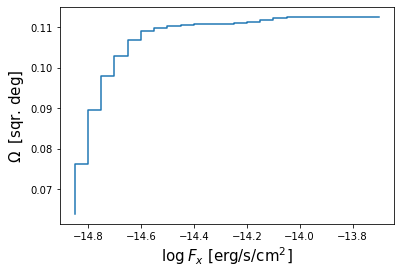

In [25]:
# Plot the cumulative histogram
bin_lo = hdu[1].data['BIN_LOW']
plt.step(bin_lo,omega)
plt.xlabel(r'$\log\: F_x$ [erg/s/cm$^2$]',size=15)
plt.ylabel(r'$\Omega \:$ [sqr. deg]',size=15)